## Introduction

In this notebook we fetch Solcast radiation and weather data using the `pvlib.iotools` helper function, and then directly feed this data into a pvlib `ModelChain`.

## Imports

In [1]:
import pvlib
from matplotlib import pyplot as plt

import os; YOUR_SOLCAST_API_KEY_HERE = os.environ["API_KEY"]  # you will need a Solcast 

## Fetch Solcast Data 

pvlib has the following helper functions to fetch Solcast API data into a format immediately usable by pvlib:

- `pvlib.iotools.get_solcast_forecast`
- `pvlib.iotools.get_solcast_live`
- `pvlib.iotools.get_solcast_historic`
- `pvlib.iotools.get_solcast_tmy`

In [2]:
# unmetered location Goodwin Creek [SURFRAD], won't consume API requests
location = pvlib.location.Location(latitude=34.2547, longitude=-89.8729)

In [3]:
# makes a call to https://api.solcast.com.au/data/historic/radiation_and_weather
weather_df, metadata = pvlib.iotools.get_solcast_historic(
    location.latitude, location.longitude,
    start="2024-07-09T00:00-07:00", end="2024-07-11T00:00-07:00",
    output_parameters=[
        # these will be converted from Solcast API names (https://docs.solcast.com.au)
        # to PVLIB convention (https://pvlib-python.readthedocs.io/en/stable/user_guide/variables_style_rules.html)
        # names and units.
        "ghi", "dni", "dhi", "air_temp", "wind_speed_10m"
    ],
    period="PT15M",
    api_key=YOUR_SOLCAST_API_KEY_HERE,
)
weather_df = weather_df.tz_convert("-07:00")
display(weather_df.head())

,temp_air,dhi,dni,ghi,wind_speed
period_mid,,,,,
2024-07-09 00:07:30-07:00,25,0,0,0,4.4
2024-07-09 00:22:30-07:00,25,0,0,0,4.4
2024-07-09 00:37:30-07:00,25,0,0,0,4.4
2024-07-09 00:52:30-07:00,25,0,0,0,4.4
2024-07-09 01:07:30-07:00,25,0,0,0,4.4


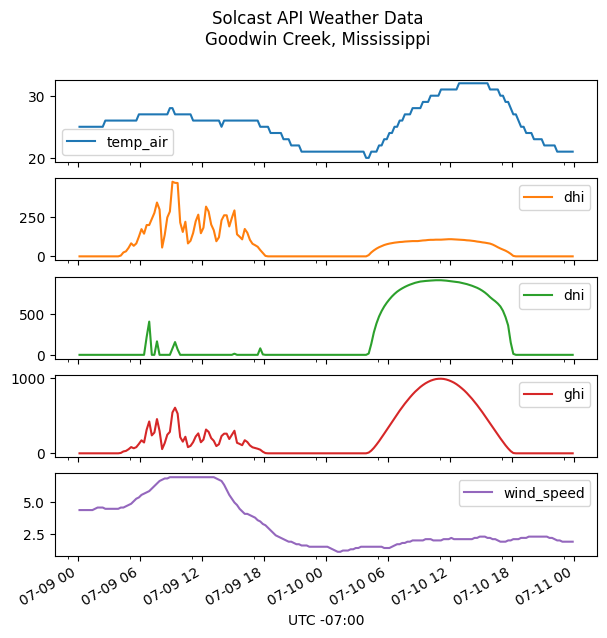

In [4]:
weather_df.plot(
    subplots=True, figsize=(7,7), 
    title="Solcast API Weather Data\nGoodwin Creek, Mississippi", 
    xlabel="UTC -07:00"
)
plt.show()

## pvlib power model

Here we pick some sensible defaults for a simple 10kW AC, 12kW DC fixed-tilt PV system.

We calculate the power production for east, south, west and north facings to show the different power profiles under these circumstances.

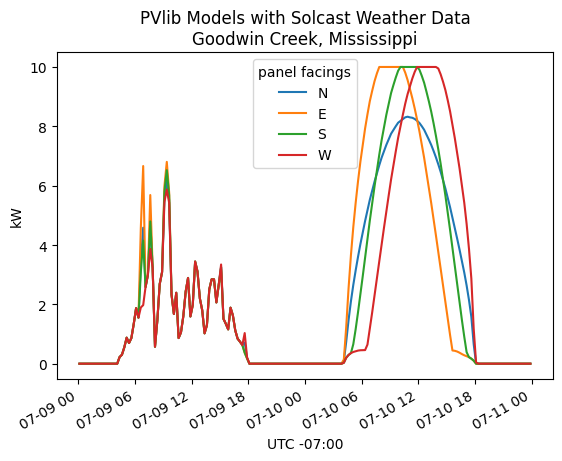

In [5]:
for panel_azimuth, facing_label in [(0, "N"), (90, "E"), (180, "S"), (-90, "W")]:
    system = pvlib.pvsystem.PVSystem(
        surface_tilt=30, 
        surface_azimuth=panel_azimuth,
        # pvwatts, DC capacity = 12 kW
        module_parameters={"pdc0": 12, "gamma_pdc": -0.003},
        # pvwatts, AC capacity = 10 kW
        inverter_parameters={"pdc0": 10/0.98, "eta_inv_nom": 0.98},
        temperature_model_parameters=pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass'],
    )
    model_chain = pvlib.modelchain.ModelChain(system, location, aoi_model="no_loss", spectral_model="no_loss")
    model_chain.run_model(weather_df)
    model_chain.results.ac.plot(label=facing_label, xlabel="UTC -07:00", ylabel="kW")

plt.title("PVlib Models with Solcast Weather Data\nGoodwin Creek, Mississippi")
plt.legend(title="panel facings")
plt.show()